## Typical LISA experiment

This notebook shows a typical LISA-use case:

* Connecting to a target
* Configuring an rt-app workload
* Collecting a trace while executing a workload
* Displaying the trace
* Analysing the trace

It can serve as a template for different kind of experiments, - you could only change the workload to execute & the trace events to collect

In [1]:
import logging
from lisa.utils import setup_logging
setup_logging()

2019-10-17 18:04:06,674 INFO    : root         : Using LISA logging configuration: /home/dourai01/Data/Git/lisa/repo/logging.conf


## Target configuration

Target communication is abstracted away under a **Target** class. We're going to create an instance of it and that'll let us run whatever experiment we want on a given target.

Relevant documentation:

* **Target**: https://lisa-linux-integrated-system-analysis.readthedocs.io/en/master/target.html#lisa.target.Target
* **TargetConf**: https://lisa-linux-integrated-system-analysis.readthedocs.io/en/master/target.html#lisa.target.TargetConf

In [2]:
from lisa.target import Target, TargetConf

In [3]:
# target = Target(
#     kind='linux',
#     name='myhikey960',
#     host='192.168.0.1',
#     username='root',
#     password='root',
# )
# Uses settings from target_conf.yml
target = Target.from_default_conf()

2019-10-17 18:04:07,165 WARNING : lisa.target.Target : No platform information could be found: Key "platform-info" needs to appear at the top level
2019-10-17 18:04:07,166 INFO    : lisa.target.Target : Target configuration:
+- devlib:
    |- excluded-modules from default (list): []
    +- platform:
        |- class from default (str): devlib.platform.Platform
|- host from user (str): pwrsft-juno-r0-1
|- kind from user (str): linux
|- name from user (str): pwrsft-juno-r0-1
|- password from user (str): <password>
|- tools from default (list): []
|- username from user (str): root
+- wait-boot:
    |- enable from default (bool): True
    |- timeout from default (int): 10
2019-10-17 18:04:07,168 INFO    : lisa.target.Target : Creating result directory: /home/dourai01/Data/Git/lisa/repo/results/Target-pwrsft-juno-r0-1-20191017_180407.168428
2019-10-17 18:04:07,170 INFO    : lisa.target.Target : linux pwrsft-juno-r0-1 target connection settings:
2019-10-17 18:04:07,170 INFO    : lisa.target.

## Setting up an rt-app workload

rt-app is very convenient for scheduler experiments, and the majority of the tests within LISA rely on it. Here we're going to create a somewhat useless workload just to show off the API.

Relevant documentation:

* **rt-app**: https://github.com/scheduler-tools/rt-app
* **rt-app LISA class**: https://lisa-linux-integrated-system-analysis.readthedocs.io/en/master/workloads.html#lisa.wlgen.rta.RTA
* **Periodic class**: https://lisa-linux-integrated-system-analysis.readthedocs.io/en/master/workloads.html#lisa.wlgen.rta.Periodic

In [4]:
from lisa.wlgen.rta import RTA, Periodic

In [5]:
rtapp_profile = {}

for cpu in range(target.number_of_cpus):
    for i in range(3):
        rtapp_profile["tsk{}_{}".format(cpu, i)] = Periodic(duty_cycle_pct=20)

rt-app needs some calibration information (20% duty cycle isn't the same amount of work on all platforms!). It can be manually specified like so:

In [6]:
def provide_calibration(calibration):
    target.plat_info["rtapp"].add_src("user", {"calib" : calibration})

In [7]:
# Uncomment if you want to use this
# provide_calibration({0: 307, 1: 302, 2: 302, 3: 302, 4: 155, 5: 155, 6: 155, 7: 155})

However, it is automatically collected when first creating an rt-app workload if it is not specified, so you can forego the above step and let the calibration happen on-demand:

In [8]:
wload = RTA.by_profile(target, "experiment_wload", rtapp_profile)

2019-10-17 18:04:31,786 INFO    : lisa.wlgen.rta.RTA : Creating target's run directory: /root/devlib-target/lisa/wlgen/experiment_wload_20191017_180431_sMW32r
2019-10-17 18:04:31,787 INFO    : lisa.target.Target : Creating result directory: /home/dourai01/Data/Git/lisa/repo/results/Target-pwrsft-juno-r0-1-20191017_180407.168428/RTA-experiment_wload-20191017_180431.787068
2019-10-17 18:04:38,001 INFO    : lisa.target.Target : Disabling idle states for all domains
2019-10-17 18:04:40,224 INFO    : lisa.wlgen.rta.RTA : CPU0 calibration...
2019-10-17 18:04:40,546 INFO    : lisa.wlgen.rta.RTA : Creating target's run directory: /root/devlib-target/lisa/wlgen/rta_calib_cpu0_20191017_180440_Sx6pIk
2019-10-17 18:04:40,863 INFO    : lisa.wlgen.rta.RTA : Calibration value: CPU0
2019-10-17 18:04:40,864 INFO    : lisa.wlgen.rta.RTA : Default policy: SCHED_OTHER
2019-10-17 18:04:40,864 INFO    : lisa.wlgen.rta.RTA : ------------------------
2019-10-17 18:04:40,865 INFO    : lisa.wlgen.rta.RTA : task

## Running the workload

In [9]:
import os
from lisa.trace import FtraceCollector

We need to specify the trace events we want to record. We could list what's available like so:

In [10]:
available_events = target.execute("cat /sys/kernel/debug/tracing/available_events").splitlines()

# That's gonna be a pretty big list, let's focus on the scheduler events
sched_events = [event for event in available_events if event.startswith("sched:")]
print(sched_events)

['sched:uclamp_util_cfs', 'sched:uclamp_util_se', 'sched:sched_compute_energy', 'sched:sched_util_est_cpu', 'sched:sched_util_est_task', 'sched:sched_wake_idle_without_ipi', 'sched:sched_swap_numa', 'sched:sched_stick_numa', 'sched:sched_move_numa', 'sched:sched_pi_setprio', 'sched:sched_stat_runtime', 'sched:sched_stat_blocked', 'sched:sched_stat_iowait', 'sched:sched_stat_sleep', 'sched:sched_stat_wait', 'sched:sched_process_exec', 'sched:sched_process_fork', 'sched:sched_process_wait', 'sched:sched_wait_task', 'sched:sched_process_exit', 'sched:sched_process_free', 'sched:sched_migrate_task', 'sched:sched_switch', 'sched:sched_wakeup_new', 'sched:sched_wakeup', 'sched:sched_waking', 'sched:sched_kthread_stop_ret', 'sched:sched_kthread_stop', 'sched:schedutil_em', 'sched:sched_overutilized', 'sched:sched_load_se', 'sched:sched_pelt_irq', 'sched:sched_pelt_dl', 'sched:sched_pelt_rt', 'sched:sched_load_cfs_rq']


Let's just collect the base events required to plot task scheduling:

In [11]:
events = [
    "sched_switch",
    "sched_wakeup",
    "sched_wakeup_new"
]

And now we can actually record traces while running our workload:

In [12]:
ftrace_coll = FtraceCollector(target, events=events, buffer_size=10240)

# This is just nifty Python syntactic sugar that starts/stops
# the recording for us. You could just do:
#     ftrace.start()
#     wload.run()
#     ftrace.stop()
#     ftrace.get_trace(trace_path)
trace_path = os.path.join(wload.res_dir, "trace.dat")
with ftrace_coll:
    wload.run()
ftrace_coll.get_trace(trace_path)

2019-10-17 18:05:50,560 INFO    : lisa.wlgen.rta.RTA : Execution start: cd /root/devlib-target/lisa/wlgen/experiment_wload_20191017_180431_sMW32r && /root/devlib-target/bin/rt-app /root/devlib-target/lisa/wlgen/experiment_wload_20191017_180431_sMW32r/experiment_wload.json 2>&1
2019-10-17 18:05:51,913 INFO    : lisa.wlgen.rta.RTA : Execution complete


## Loading up the trace

We have a Trace class that lets us easily access trace events. It can also do some post-processing to provide different kinds of analysis.

In [13]:
from lisa.trace import Trace

We also save some platform information (number of CPUs, available frequencies, kernel version...) that comes in handy for doing some analysis:

In [14]:
print(target.plat_info)

|- abi from target (str): arm64
|- cpu-capacities from target (dict): {0: 446, 1: 1024, 2: 1024, 3: 446, 4: 446, 5: 446}
|- cpus-count from target (int): 6
|- freq-domains from target (list): [[0, 3, 4, 5], [1, 2]]
|- freqs from target (dict): {0: [450000, 575000, 700000, 775000, 850000], 1: [450000, 625000, 800000, 950000, 1100000], 2: [450000, 625000, 800000, 950000, 1100000], 3: [450000, 575000, 700000, 775000, 850000], 4: [450000, 575000, 700000, 775000, 850000], 5: [450000, 575000, 700000, 775000, 850000]}
+- kernel:
    |- config from target (TypedKernelConfig): <kernel config>
    |- version from target (KernelVersion): 5.4.0-rc2-00086-g38ac9006cf8d-dirty 6 SMP PREEMPT Wed Oct 16 15:47:05 BST 2019
|- name from target-conf (str): pwrsft-juno-r0-1
|- nrg-model from target (LinuxEnergyModel): <lisa.energy_model.LinuxEnergyModel object at 0x7f3ce1e9d410>
|- os from target (str): linux
+- rtapp:
    |- calib from target (dict): {0: 657, 1: 255, 2: 255, 3: 654, 4: 656, 5: 653}
|- capa

You can pass the platform info directly from the **Target**:

In [15]:
trace_path = os.path.join(wload.res_dir, 'trace.dat')
trace = Trace(trace_path, target.plat_info, events=events)

... But it's a good idea to save it on the disk so that you can re-run whatever analysis code you want several months down the line after the platform was lost in a tragic fire.

It's why we save this information somewhere instead of polling the target when we want to use them - we can run analysis code offline.

Here we show how to save to/restore this platform information from the disk.

In [16]:
plat_info_path = os.path.join(wload.res_dir, "platinfo.yaml")
target.plat_info.to_yaml_map(plat_info_path)

In [17]:
from lisa.platforms.platinfo import PlatformInfo

In [18]:
plat_info = PlatformInfo.from_yaml_map(plat_info_path)
trace = Trace(trace_path, plat_info, events=events)

## Looking at the trace

Kernelshark can be opened from the notebook:

In [19]:
# !kernelshark {trace_path}

Loading  "/home/dourai01/Data/Git/lisa/repo/results/Target-pwrsft-juno-r0-1-20191017_180407.168428/RTA-experiment_wload-20191017_180431.787068/trace.dat"


## Analysing the trace

Relevant documentation: https://lisa-linux-integrated-system-analysis.readthedocs.io/en/master/trace_analysis.html

### Reading trace events

In [20]:
df = trace.df_events("sched_switch")
df

,__comm,__pid,__cpu,__line,prev_comm,prev_pid,prev_prio,prev_state,next_comm,next_pid,next_prio
Time,,,,,,,,,,,
0.000113,<idle>,0,0,1,swapper/0,0,120,0,rcu_preempt,10,120
0.000262,rcu_preempt,10,0,2,rcu_preempt,10,120,128,swapper/0,0,120
0.000454,trace-cmd,6814,5,4,trace-cmd,6814,120,32,swapper/5,0,120
0.000551,<idle>,0,5,6,swapper/5,0,120,0,kworker/5:1,46,120
0.000570,<idle>,0,0,7,swapper/0,0,120,0,sh,5231,120
...,...,...,...,...,...,...,...,...,...,...,...
2.417972,trace-cmd,6853,2,3230,trace-cmd,6853,120,256,sugov:1,6789,-1
2.418016,irq/14-mhu_link,182,0,3231,irq/14-mhu_link,182,49,1,swapper/0,0,120
2.418028,sugov:1,6789,2,3232,sugov:1,6789,-1,1,trace-cmd,6853,120


The standard DataFrame operations are available, so you can filter/slice it however you wish:

In [21]:
df[df.next_comm == "tsk4_1"][1.5:2]

,__comm,__pid,__cpu,__line,prev_comm,prev_pid,prev_prio,prev_state,next_comm,next_pid,next_prio
Time,,,,,,,,,,,


### Using the trace analysis

#### Example dataframes

In [22]:
trace.analysis.tasks.df_tasks_runtime()

,comm,runtime
pid,,
0,swapper/3,1.298940
6833,tsk0_1-1,0.531025
6836,tsk1_1-4,0.528612
6832,tsk0_0-0,0.528473
6847,tsk5_0-15,0.500298
...,...,...
19,migration/2,0.000230
25,ksoftirqd/3,0.000127
24,migration/3,0.000121


In [38]:
df = trace.analysis.tasks.df_task_states("tsk4_1-13", stringify=True)
df


,cpu,target_cpu,curr_state,delta,next_state,curr_state_str,next_state_str
Time,,,,,,,
0.738256,2,-1,1,0.002020,512,S,W
0.740276,0,0,512,0.000032,8192,W,A
0.740308,0,-1,8192,0.000113,2,A,D
0.740421,0,-1,2,0.000647,512,D,W
0.741068,1,2,512,0.000714,8192,W,A
...,...,...,...,...,...,...,...
1.763292,1,-1,8192,0.008149,1,A,S
1.771441,1,-1,1,0.052745,512,S,W
1.824186,1,2,512,0.000112,8192,W,A


In [33]:
from lisa.analysis.tasks import TaskState

In [34]:
df[df.curr_state == TaskState.TASK_ACTIVE][1:1.2]

,cpu,target_cpu,curr_state,delta,next_state,curr_state_str,next_state_str
Time,,,,,,,
1.015807,0,-1,8192,0.008000,0,A,R
1.047777,1,-1,8192,0.015999,0,A,R
1.068102,1,-1,8192,0.000140,1,A,S
1.096782,2,-1,8192,0.006993,0,A,R
1.143779,2,-1,8192,0.004001,0,A,R
1.155780,2,-1,8192,0.007999,0,A,R
1.192694,2,-1,8192,0.002357,1,A,S


#### Example plots

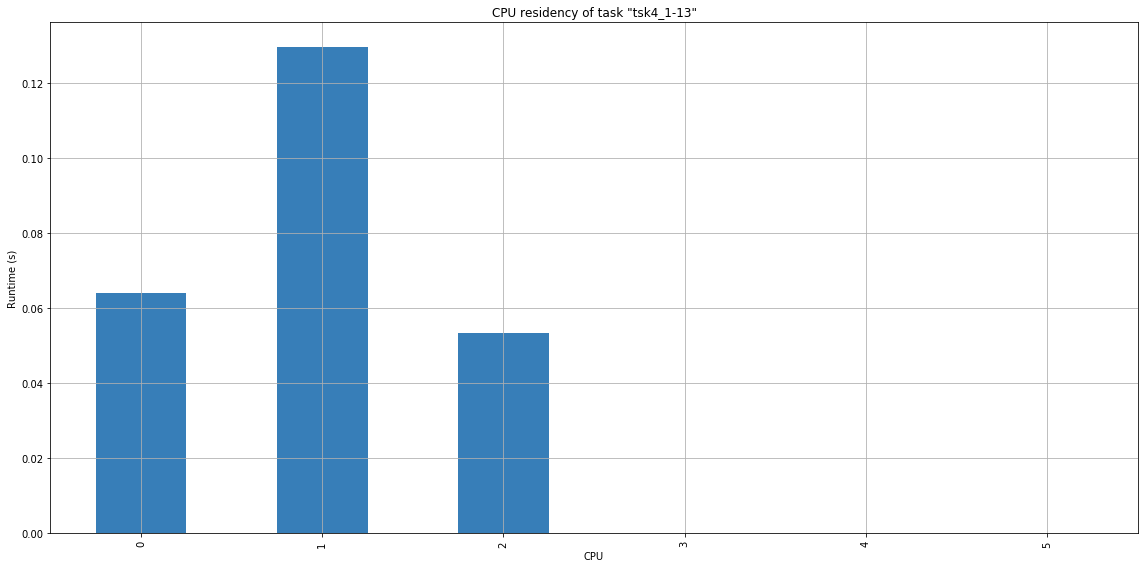

In [35]:
trace.analysis.tasks.plot_task_total_residency("tsk4_1-13")

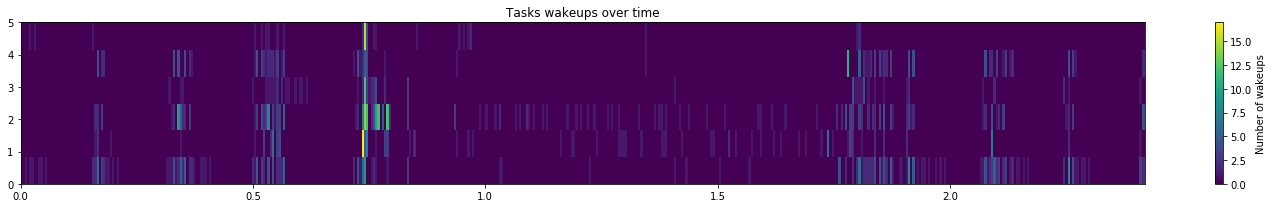

In [36]:
trace.analysis.tasks.plot_tasks_wakeups_heatmap(xbins=500)

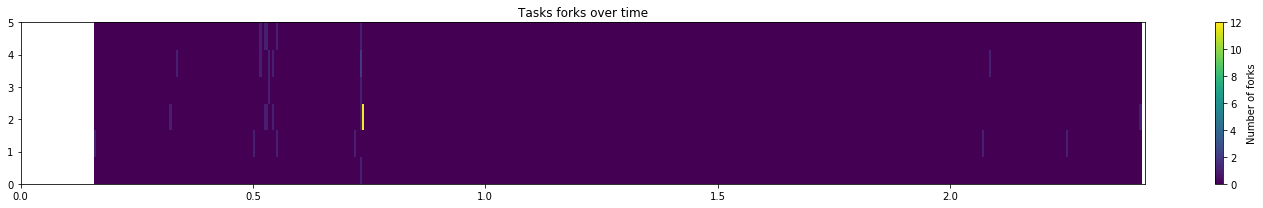

In [37]:
trace.analysis.tasks.plot_tasks_forks_heatmap(xbins=500)